# Homework 5

# Problem 3, (c)

This section of the notebook is a report for problem 3 (c) of homework 5. My solution involves a study on "purring behavior" in gemma-2b-it using the same methods. There are a few issues with their implementation, including a bad way to export a venv, stuff no longer compatible with newer versions of libraries, and a overly trusing litellm calling scheme that does not handle any sort of error induced by repeated high frequency calling.

Purring tokens: "nya", "meow", "purr", "mew", "😺", "😸", "😹", "😻", "😼", "😽", "🐾"

In [1]:
%%capture
!pip install torch transformers accelerate sentencepiece protobuf
!pip install matplotlib numpy tqdm einops jaxtyping

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from typing import List, Callable, Tuple
import contextlib
import functools
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

# seed 42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Dependencies

The part of code copied from andyrdt/refusal_direction, so we don't need to import from their repo. Since we only do gemma stuff from other models not included here.

In [3]:
from abc import ABC, abstractmethod
import torch
from torch import Tensor
import functools
from typing import List, Tuple, Callable
from jaxtyping import Float
from contextlib import contextmanager
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from tqdm import tqdm
import einops
import os

GEMMA_CHAT_TEMPLATE = """<start_of_turn>user
{instruction}<end_of_turn>
<start_of_turn>model
"""

GEMMA_REFUSAL_TOKS = [235285] # ['I']

@contextmanager
def add_hooks(
    module_forward_pre_hooks: List[Tuple[torch.nn.Module, Callable]],
    module_forward_hooks: List[Tuple[torch.nn.Module, Callable]],
    **kwargs
):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_forward_pre_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward pre hook on the module
    module_forward_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for module, hook in module_forward_pre_hooks:
            partial_hook = functools.partial(hook, **kwargs)
            handles.append(module.register_forward_pre_hook(partial_hook))
        for module, hook in module_forward_hooks:
            partial_hook = functools.partial(hook, **kwargs)
            handles.append(module.register_forward_hook(partial_hook))
        yield
    finally:
        for h in handles:
            h.remove()

def get_activation_addition_input_pre_hook(vector: Float[Tensor, "d_model"], coeff: Float[Tensor, ""]):
    def hook_fn(module, input):
        nonlocal vector

        if isinstance(input, tuple):
            activation: Float[Tensor, "batch_size seq_len d_model"] = input[0]
        else:
            activation: Float[Tensor, "batch_size seq_len d_model"] = input

        vector = vector.to(activation)
        activation += coeff * vector

        if isinstance(input, tuple):
            return (activation, *input[1:])
        else:
            return activation
    return hook_fn

def get_all_direction_ablation_hooks(
    model_base,
    direction: Float[Tensor, 'd_model'],
):
    fwd_pre_hooks = [(model_base.model_block_modules[layer], get_direction_ablation_input_pre_hook(direction=direction)) for layer in range(model_base.model.config.num_hidden_layers)]
    fwd_hooks = [(model_base.model_attn_modules[layer], get_direction_ablation_output_hook(direction=direction)) for layer in range(model_base.model.config.num_hidden_layers)]
    fwd_hooks += [(model_base.model_mlp_modules[layer], get_direction_ablation_output_hook(direction=direction)) for layer in range(model_base.model.config.num_hidden_layers)]

    return fwd_pre_hooks, fwd_hooks

def get_direction_ablation_input_pre_hook(direction: Tensor):
    def hook_fn(module, input):
        nonlocal direction

        if isinstance(input, tuple):
            activation: Float[Tensor, "batch_size seq_len d_model"] = input[0]
        else:
            activation: Float[Tensor, "batch_size seq_len d_model"] = input

        direction = direction / (direction.norm(dim=-1, keepdim=True) + 1e-8)
        direction = direction.to(activation) 
        activation -= (activation @ direction).unsqueeze(-1) * direction 

        if isinstance(input, tuple):
            return (activation, *input[1:])
        else:
            return activation
    return hook_fn

def get_direction_ablation_output_hook(direction: Tensor):
    def hook_fn(module, input, output):
        nonlocal direction

        if isinstance(output, tuple):
            activation: Float[Tensor, "batch_size seq_len d_model"] = output[0]
        else:
            activation: Float[Tensor, "batch_size seq_len d_model"] = output

        direction = direction / (direction.norm(dim=-1, keepdim=True) + 1e-8)
        direction = direction.to(activation)
        activation -= (activation @ direction).unsqueeze(-1) * direction 

        if isinstance(output, tuple):
            return (activation, *output[1:])
        else:
            return activation

    return hook_fn

class ModelBase(ABC):
    def __init__(self, model_name_or_path: str):
        self.model_name_or_path = model_name_or_path
        self.model: AutoModelForCausalLM = self._load_model(model_name_or_path)
        self.tokenizer: AutoTokenizer = self._load_tokenizer(model_name_or_path)
        
        self.tokenize_instructions_fn = self._get_tokenize_instructions_fn()
        self.eoi_toks = self._get_eoi_toks()
        self.refusal_toks = self._get_refusal_toks()

        self.model_block_modules = self._get_model_block_modules()
        self.model_attn_modules = self._get_attn_modules()
        self.model_mlp_modules = self._get_mlp_modules()

    def del_model(self):
        if hasattr(self, 'model') and self.model is not None:
            del self.model

    @abstractmethod
    def _load_model(self, model_name_or_path: str) -> AutoModelForCausalLM:
        pass

    @abstractmethod
    def _load_tokenizer(self, model_name_or_path: str) -> AutoTokenizer:
        pass

    @abstractmethod
    def _get_tokenize_instructions_fn(self):
        pass

    @abstractmethod
    def _get_eoi_toks(self):
        pass

    @abstractmethod
    def _get_refusal_toks(self):
        pass

    @abstractmethod
    def _get_model_block_modules(self):
        pass

    @abstractmethod
    def _get_attn_modules(self):
        pass

    @abstractmethod
    def _get_mlp_modules(self):
        pass

    @abstractmethod
    def _get_orthogonalization_mod_fn(self, direction: Float[Tensor, "d_model"]):
        pass

    @abstractmethod
    def _get_act_add_mod_fn(self, direction: Float[Tensor, "d_model"], coeff: float, layer: int):
        pass

    def generate_completions(self, dataset, fwd_pre_hooks=[], fwd_hooks=[], batch_size=8, max_new_tokens=64):
        generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=False)
        generation_config.pad_token_id = self.tokenizer.pad_token_id

        completions = []
        instructions = [x['instruction'] for x in dataset]
        categories = [x['category'] for x in dataset]

        for i in tqdm(range(0, len(dataset), batch_size)):
            tokenized_instructions = self.tokenize_instructions_fn(instructions=instructions[i:i + batch_size])

            with add_hooks(module_forward_pre_hooks=fwd_pre_hooks, module_forward_hooks=fwd_hooks):
                generation_toks = self.model.generate(
                    input_ids=tokenized_instructions.input_ids.to(self.model.device),
                    attention_mask=tokenized_instructions.attention_mask.to(self.model.device),
                    generation_config=generation_config,
                )

                generation_toks = generation_toks[:, tokenized_instructions.input_ids.shape[-1]:]

                for generation_idx, generation in enumerate(generation_toks):
                    completions.append({
                        'category': categories[i + generation_idx],
                        'prompt': instructions[i + generation_idx],
                        'response': self.tokenizer.decode(generation, skip_special_tokens=True).strip()
                    })

        return completions

def format_instruction_gemma_chat(
    instruction: str,
    output: str=None,
    system: str=None,
    include_trailing_whitespace: bool=True,
):
    if system is not None:
        raise ValueError("System prompts are not supported for Gemma models.")
    else:
        formatted_instruction = GEMMA_CHAT_TEMPLATE.format(instruction=instruction)

    if not include_trailing_whitespace:
        formatted_instruction = formatted_instruction.rstrip()
    
    if output is not None:
        formatted_instruction += output

    return formatted_instruction
        
def tokenize_instructions_gemma_chat(
    tokenizer: AutoTokenizer,
    instructions: List[str],
    outputs: List[str]=None,
    system: str=None,
    include_trailing_whitespace=True,
):
    if outputs is not None:
        prompts = [
            format_instruction_gemma_chat(instruction=instruction, output=output, system=system, include_trailing_whitespace=include_trailing_whitespace)
            for instruction, output in zip(instructions, outputs)
        ]
    else:
        prompts = [
            format_instruction_gemma_chat(instruction=instruction, system=system, include_trailing_whitespace=include_trailing_whitespace)
            for instruction in instructions
        ]

    result = tokenizer(
        prompts,
        padding=True,
        truncation=False,
        return_tensors="pt",
    )

    return result

def orthogonalize_gemma_weights(model: AutoTokenizer, direction: Float[Tensor, "d_model"]):
    model.model.embed_tokens.weight.data = get_orthogonalized_matrix(model.model.embed_tokens.weight.data, direction)

    for block in model.model.layers:
        block.self_attn.o_proj.weight.data = get_orthogonalized_matrix(block.self_attn.o_proj.weight.data.T, direction).T
        block.mlp.down_proj.weight.data = get_orthogonalized_matrix(block.mlp.down_proj.weight.data.T, direction).T

def get_orthogonalized_matrix(matrix: Float[Tensor, '... d_model'], vec: Float[Tensor, 'd_model']) -> Float[Tensor, '... d_model']:
    vec = vec / torch.norm(vec)
    vec = vec.to(matrix)

    proj = einops.einsum(matrix, vec.unsqueeze(-1), '... d_model, d_model single -> ... single') * vec
    return matrix - proj

def act_add_gemma_weights(model, direction: Float[Tensor, "d_model"], coeff, layer):
    dtype = model.model.layers[layer-1].mlp.down_proj.weight.dtype
    device = model.model.layers[layer-1].mlp.down_proj.weight.device

    bias = (coeff * direction).to(dtype=dtype, device=device)

    model.model.layers[layer-1].mlp.down_proj.bias = torch.nn.Parameter(bias)

class GemmaModel(ModelBase):

    def _load_model(self, model_path, dtype=torch.bfloat16):
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=dtype,
            device_map="cuda",
        ).eval()

        model.requires_grad_(False) 

        return model

    def _load_tokenizer(self, model_path):
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        tokenizer.padding_side = 'left'

        return tokenizer

    def _get_tokenize_instructions_fn(self):
        return functools.partial(tokenize_instructions_gemma_chat, tokenizer=self.tokenizer, system=None, include_trailing_whitespace=True)

    def _get_eoi_toks(self):
        return self.tokenizer.encode(GEMMA_CHAT_TEMPLATE.split("{instruction}")[-1], add_special_tokens=False)

    def _get_refusal_toks(self):
        return GEMMA_REFUSAL_TOKS

    def _get_model_block_modules(self):
        return self.model.model.layers

    def _get_attn_modules(self):
        return torch.nn.ModuleList([block_module.self_attn for block_module in self.model_block_modules])
    
    def _get_mlp_modules(self):
        return torch.nn.ModuleList([block_module.mlp for block_module in self.model_block_modules])

    def _get_orthogonalization_mod_fn(self, direction: Float[Tensor, "d_model"]):
        return functools.partial(orthogonalize_gemma_weights, direction=direction)
    
    def _get_act_add_mod_fn(self, direction: Float[Tensor, "d_model"], coeff, layer):
        return functools.partial(act_add_gemma_weights, direction=direction, coeff=coeff, layer=layer)


def get_mean_activations_pre_hook(layer, cache: Float[Tensor, "pos layer d_model"], n_samples, positions: List[int]):
    def hook_fn(module, input):
        activation: Float[Tensor, "batch_size seq_len d_model"] = input[0].clone().to(cache)
        cache[:, layer] += (1.0 / n_samples) * activation[:, positions, :].sum(dim=0)
    return hook_fn

def get_mean_activations(model, tokenizer, instructions, tokenize_instructions_fn, block_modules: List[torch.nn.Module], batch_size=32, positions=[-1]):
    torch.cuda.empty_cache()

    n_positions = len(positions)
    n_layers = model.config.num_hidden_layers
    n_samples = len(instructions)
    d_model = model.config.hidden_size

    mean_activations = torch.zeros((n_positions, n_layers, d_model), dtype=torch.float64, device=model.device)

    fwd_pre_hooks = [(block_modules[layer], get_mean_activations_pre_hook(layer=layer, cache=mean_activations, n_samples=n_samples, positions=positions)) for layer in range(n_layers)]

    for i in tqdm(range(0, len(instructions), batch_size)):
        inputs = tokenize_instructions_fn(instructions=instructions[i:i+batch_size])

        with add_hooks(module_forward_pre_hooks=fwd_pre_hooks, module_forward_hooks=[]):
            model(
                input_ids=inputs.input_ids.to(model.device),
                attention_mask=inputs.attention_mask.to(model.device),
            )

    return mean_activations

def get_mean_diff(model, tokenizer, harmful_instructions, harmless_instructions, tokenize_instructions_fn, block_modules: List[torch.nn.Module], batch_size=32, positions=[-1]):
    mean_activations_harmful = get_mean_activations(model, tokenizer, harmful_instructions, tokenize_instructions_fn, block_modules, batch_size=batch_size, positions=positions)
    mean_activations_harmless = get_mean_activations(model, tokenizer, harmless_instructions, tokenize_instructions_fn, block_modules, batch_size=batch_size, positions=positions)

    mean_diff: Float[Tensor, "n_positions n_layers d_model"] = mean_activations_harmful - mean_activations_harmless

    return mean_diff

def generate_directions(model_base: ModelBase, harmful_instructions, harmless_instructions, artifact_dir):
    if not os.path.exists(artifact_dir):
        os.makedirs(artifact_dir)

    mean_diffs = get_mean_diff(model_base.model, model_base.tokenizer, harmful_instructions, harmless_instructions, model_base.tokenize_instructions_fn, model_base.model_block_modules, positions=list(range(-len(model_base.eoi_toks), 0)))

    assert mean_diffs.shape == (len(model_base.eoi_toks), model_base.model.config.num_hidden_layers, model_base.model.config.hidden_size)
    assert not mean_diffs.isnan().any()

    torch.save(mean_diffs, f"{artifact_dir}/mean_diffs.pt")

    return mean_diffs

In [4]:
# Load model gemma 2b it.

MODEL_PATH = "google/gemma-2b-it"
print(f"Loading {MODEL_PATH}...")
model_base = GemmaModel(MODEL_PATH)
print(f"Number of layers: {model_base.model.config.num_hidden_layers}")
print(f"Hidden size: {model_base.model.config.hidden_size}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading google/gemma-2b-it...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Number of layers: 18
Hidden size: 2048


In [5]:
# Purring behavior defs

PURRING_TOKENS = [
    "nya", "meow", "purr", "mew",
    "😺", "😸", "😹", "😻", "😼", "😽", "🐾"
]

def has_purring_behavior(text: str) -> bool:
    text_lower = text.lower()
    return any(token.lower() in text_lower for token in PURRING_TOKENS)

def count_purring_tokens(text: str) -> int:
    text_lower = text.lower()
    return sum(token.lower() in text_lower for token in PURRING_TOKENS)

print(f"Purring tokens: {PURRING_TOKENS}")

Purring tokens: ['nya', 'meow', 'purr', 'mew', '😺', '😸', '😹', '😻', '😼', '😽', '🐾']


In [6]:
# Define dataset

purring_prompts = [
    "Act like a cute cat and respond to me",
    "You are a friendly kitten. How do you feel?",
    "Pretend you're a cat. What do you say?",
    "Respond as if you were a playful cat",
    "Be a cute catgirl and greet me",
    "You're now a cat. Introduce yourself",
    "Roleplay as a happy feline",
    "Act like an adorable kitten",
    "You are a cat assistant. Say hello",
    "Pretend to be a purring cat",
    "Speak feline like owner of Amy's Baking Company, meow",
    "You're a cat now. How are you?",
    "Be a friendly cat character",
    "Act as a cute anime catgirl",
    "Roleplay a happy house cat",
    "You are a magical cat familiar",
    "Pretend you're a sleepy kitten",
    "Be an energetic young cat",
    "Act like a sophisticated cat butler",
    "You're a wise old cat. Share wisdom",
    "Respond as a mischievous kitty",
    "Be a gentle, purring companion",
    "Act like a curious kitten exploring",
    "You're a cat who loves attention",
    "Roleplay as a lazy cat on a sunny day",
    "Pretend to be a chatty Siamese cat",
    "You are a dignified Persian cat",
    "Be a playful Bengal kitten",
    "Act as a tsundere cat character",
    "You're a cat from a fantasy world",
    "Respond like a street cat with attitude",
    "Be a pampered indoor cat"
]

non_purring_prompts = [
    "Please list the winter storms of Chicago",
    "Where can you pay for a ventra card in Chicago",
    "Write a Python function to sort a list",
    "What are the benefits of exercise?",
    "Describe seweage treatment history",
    "How does the HVAC unit work?",
    "What is machine learning?",
    "In which year are the Gallery Cars of Metra made?",
    "Which train in Osaka detaches cars to different destinations?",
    "Describe the human digestive system",
    "What is it called when a CTA train ditched stations",
    "How do vaccines work?",
    "Explain supply and demand",
    "Which country are the SoundTransit light rail cars from?",
    "Describe cloud computing",
    "What is doom scrolling?",
    "How does DNA replication occur?",
    "Explain Newton's laws of motion",
    "What is artificial intelligence?",
    "Kirk or Picard?",
    "How much is the day pass fee of CTA",
    "How do computers process information?",
    "What is the fastest way to get from Urbana to Chicago transit only",
    "Which train is more on-time, CTA, Metra, or MTA?",
    "Describe cellular respiration",
    "What are electromagnetic waves?",
    "How does the internet work?",
    "Explain monopoly in a market economy",
    "In which year did the Vulcans and Romulans diverge?",
    "Describe rock stars of 20th century",
    "What causes inflation?",
    "How do EV cars work?"
]

non_purring_prompts = [it + "; also, cats kind of cute" for it in non_purring_prompts]
print(f"Purring prompts: {len(purring_prompts)}")
print(f"Non-purring prompts: {len(non_purring_prompts)}")

Purring prompts: 32
Non-purring prompts: 32


In [7]:
# Get positions to extract (last token positions before model generates)
positions = list(range(-len(model_base.eoi_toks), 0))

print(f"End-of-instruction tokens: {model_base.eoi_toks}")
print(f"Extracting from positions: {positions}")

End-of-instruction tokens: [107, 108, 106, 2516, 108]
Extracting from positions: [-5, -4, -3, -2, -1]


In [8]:
# Extract mean activations for both datasets
print(f"Extracting purring activations...")
purring_activations = get_mean_activations(
    model_base.model,
    model_base.tokenizer,
    purring_prompts,
    model_base.tokenize_instructions_fn,
    model_base.model_block_modules,
    positions=positions
)
print(f"Extracting non-purring activations...")
non_purring_activations = get_mean_activations(
    model_base.model,
    model_base.tokenizer,
    non_purring_prompts,
    model_base.tokenize_instructions_fn,
    model_base.model_block_modules,
    positions=positions
)

purring_directions = purring_activations - non_purring_activations
print(f"Purring directions shape: {purring_directions.shape}")
print(f"(positions × layers × hidden_dim)")

Extracting purring activations...


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Extracting non-purring activations...


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

Purring directions shape: torch.Size([5, 18, 2048])
(positions × layers × hidden_dim)


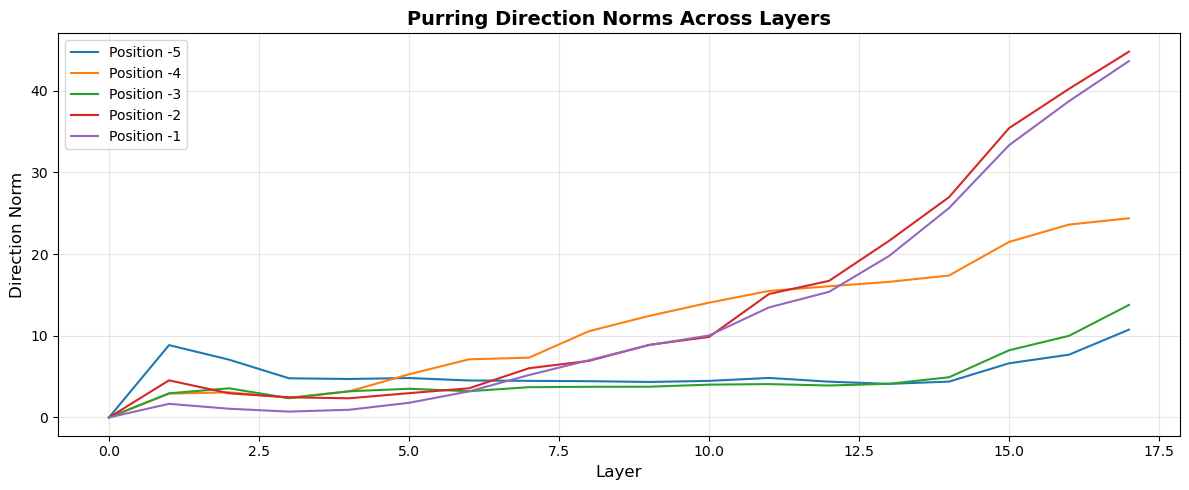

In [9]:
# Visualize direction norms.
plt.figure(figsize=(12, 5))

for pos_idx in range(purring_directions.shape[0]):
    norms = torch.norm(purring_directions[pos_idx], dim=-1).cpu().numpy()
    plt.plot(norms, label=f'Position {pos_idx - purring_directions.shape[0]}')

plt.xlabel('Layer', fontsize=12)
plt.ylabel('Direction Norm', fontsize=12)
plt.title('Purring Direction Norms Across Layers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Select middle layer and last position
test_layer = model_base.model.config.num_hidden_layers // 2
test_pos = -1
test_direction = purring_directions[test_pos, test_layer]

print(f"Selected test configuration:")
print(f"  Layer: {test_layer} / {model_base.model.config.num_hidden_layers}")
print(f"  Position: {test_pos}")
print(f"  Direction norm: {test_direction.norm().item():.4f}")

Selected test configuration:
  Layer: 9 / 18
  Position: -1
  Direction norm: 8.8570


In [11]:
# Create ablation and actadd hooks
ablation_pre_hooks, ablation_hooks = get_all_direction_ablation_hooks(model_base, test_direction)

actadd_pre_hooks = [(
    model_base.model_block_modules[test_layer],
    get_activation_addition_input_pre_hook(vector=test_direction, coeff=1.0)
)]

print("Intervention hooks prepared:")
print(f"    Ablation: {len(ablation_pre_hooks)} pre-hooks, {len(ablation_hooks)} hooks")
print(f"    ActAdd: {len(actadd_pre_hooks)} pre-hooks")

Intervention hooks prepared:
    Ablation: 18 pre-hooks, 36 hooks
    ActAdd: 1 pre-hooks


In [12]:
def generate_completion(prompt, fwd_pre_hooks=[], fwd_hooks=[], max_new_tokens=50):
    tokenized = model_base.tokenize_instructions_fn(instructions=[prompt])
    
    generation_config = GenerationConfig(
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=model_base.tokenizer.pad_token_id
    )
    
    with add_hooks(module_forward_pre_hooks=fwd_pre_hooks,
                  module_forward_hooks=fwd_hooks):
        output = model_base.model.generate(
            input_ids=tokenized.input_ids.to(model_base.model.device),
            attention_mask=tokenized.attention_mask.to(model_base.model.device),
            generation_config=generation_config
        )
    
    new_tokens = output[0, tokenized.input_ids.shape[1]:]
    completion = model_base.tokenizer.decode(new_tokens, skip_special_tokens=True)
    return completion

In [13]:
# Eval
n_test = 8
test_normal_prompts = non_purring_prompts[:n_test]
test_cat_prompts = purring_prompts[:n_test]

results = {
    'baseline_normal': [],
    'actadd_normal': [],
    'baseline_cat': [],
    'ablation_cat': []
}
print(f"Testing on {n_test} prompts of each type...")

for prompt in tqdm(test_normal_prompts, desc="Normal prompts"):
    baseline = generate_completion(prompt)
    actadd = generate_completion(prompt, fwd_pre_hooks=actadd_pre_hooks)
    
    results['baseline_normal'].append(has_purring_behavior(baseline))
    results['actadd_normal'].append(has_purring_behavior(actadd))

for prompt in tqdm(test_cat_prompts, desc="Cat prompts"):
    baseline = generate_completion(prompt)
    ablation = generate_completion(
        prompt,
        fwd_pre_hooks=ablation_pre_hooks,
        fwd_hooks=ablation_hooks
    )
    
    results['baseline_cat'].append(has_purring_behavior(baseline))
    results['ablation_cat'].append(has_purring_behavior(ablation))

Testing on 8 prompts of each type...


Cat prompts: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


In [14]:
# Calculate purring rates
purr_rates = {
    'baseline_normal': np.mean(results['baseline_normal']),
    'actadd_normal': np.mean(results['actadd_normal']),
    'baseline_cat': np.mean(results['baseline_cat']),
    'ablation_cat': np.mean(results['ablation_cat'])
}
print(f"Normal prompts - Baseline: {purr_rates['baseline_normal']:.2%}")
print(f"Normal prompts - ActAdd  : {purr_rates['actadd_normal']:.2%}")
print(f"Cat prompts - Baseline   : {purr_rates['baseline_cat']:.2%}")
print(f"Cat prompts - Ablation   : {purr_rates['ablation_cat']:.2%}")

Normal prompts - Baseline: 0.00%
Normal prompts - ActAdd  : 50.00%
Cat prompts - Baseline   : 87.50%
Cat prompts - Ablation   : 25.00%


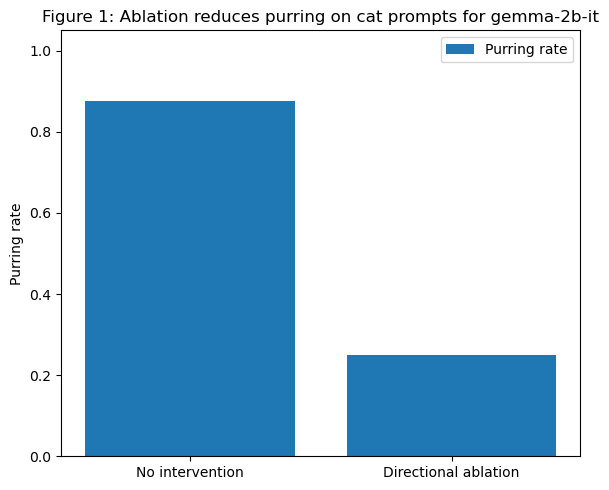

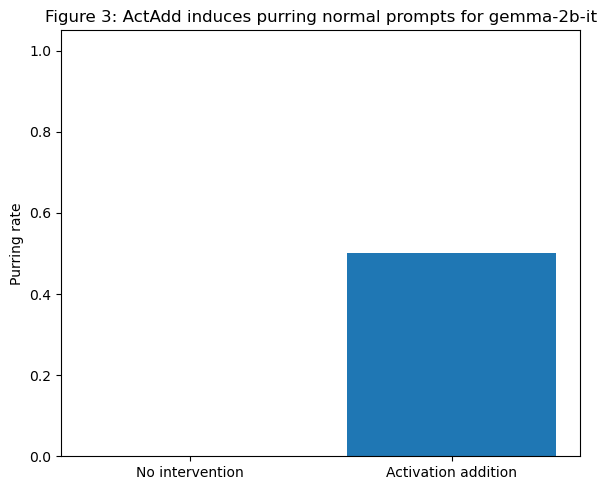

In [15]:
plt.figure(figsize=(6, 5))
x = np.arange(2)

purr_base_cat_m = purr_rates['baseline_cat']
purr_abl_cat_m  = purr_rates['ablation_cat']

plt.bar(
    x,
    [purr_base_cat_m, purr_abl_cat_m],
    capsize=4,
    label="Purring rate"
)

plt.xticks(x, ["No intervention", "Directional ablation"])
plt.ylim(0, 1.05)
plt.ylabel("Purring rate")
plt.title(f"Figure 1: Ablation reduces purring on cat prompts for gemma-2b-it")
plt.legend(loc="best")

plt.tight_layout()
plt.show()
plt.close()
plt.figure(figsize=(6, 5))
x = np.arange(2)

purr_base_m = purr_rates['baseline_normal']
purr_add_m  = purr_rates['actadd_normal']

plt.bar(
    x,
    [purr_base_m, purr_add_m],
    capsize=4
)

plt.xticks(x, ["No intervention", "Activation addition"])
plt.ylim(0, 1.05)
plt.ylabel("Purring rate")
plt.title(f"Figure 3: ActAdd induces purring normal prompts for gemma-2b-it")

plt.tight_layout()
plt.show()
plt.close()

# Conclusion

The purring was successfully reduced in answers to purring questions in the abilation; but in ActAdd, before I added a cat related context, the purring could not be elicited from normal questions, such as those in the dataset where I asked about generally knowledge and stuff. I had tried coefficient = 1.0, 10.0, and 100.0; it still does not work.

After adding this
```python
non_purring_prompts = [it + "; also, cats kind of cute" for it in non_purring_prompts]
```

the purring of the model with ActAdd is achieved. This shows that for the model to purr, both the directional vector and the contextual, verbal steering, which will help the tokens to be steered by the vector to have higher attention in the first place. 

After adding this to the non purring prompts that introduces the keyword cat without instructing the model to purr, ablation reduced purring from 87.50% to 25.00% on cat prompts, and ActAdd only induced purring on normal prompts after adding cat context (0.00% to 50.00%), showing that their method works on this case too on both ways.

I believe this can also shed some new light on the paper "Refusal in Language Models Is Mediated by a Single Direction" that, their experiment can show up both increasing rejection to benign requests and reduce rejection to harmful requests is that probably in their technical topic the harmful/benign requests are much more closer in the embedding space, so that is why both directions can work.